#Student Name: 
#ECE 595 Machine Learning II
#Project 3: GAN - Student Code

In [1]:
#Import necessary packages
import numpy as np
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from __future__ import print_function

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ECE595_projects/DLproject3/
mnist_classifier = load_model('mnist_classifier.h5')

Mounted at /content/drive
/content/drive/MyDrive/ECE595_projects/DLproject3


#Part 1: Implementing the GAN

Epoch 10000
10000: [Discriminaotr loss: 0.052269, acc: 0.500000]  [GAN loss: 5.562355, acc: 0.000000]


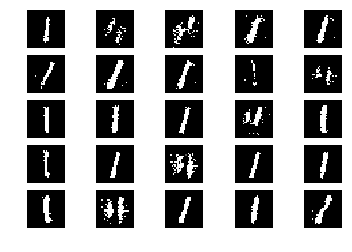

Epoch 20000
20000: [Discriminaotr loss: 0.046704, acc: 0.500000]  [GAN loss: 6.236892, acc: 0.000000]


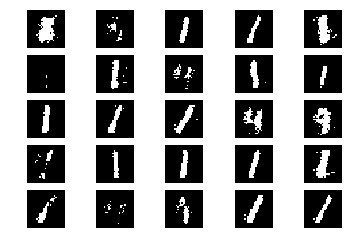

Epoch 30000
30000: [Discriminaotr loss: 0.042698, acc: 0.500000]  [GAN loss: 7.222023, acc: 0.000000]


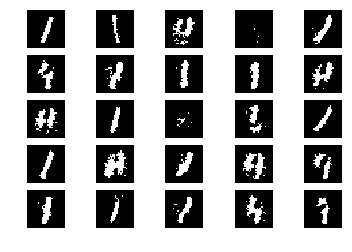

Epoch 40000
40000: [Discriminaotr loss: 0.033406, acc: 0.500000]  [GAN loss: 10.151867, acc: 0.000000]


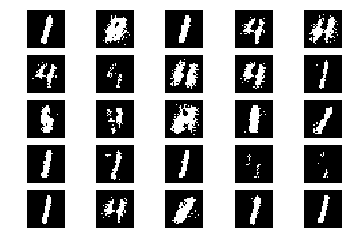

Epoch 50000
50000: [Discriminaotr loss: 0.037278, acc: 0.500000]  [GAN loss: 9.673967, acc: 0.000000]


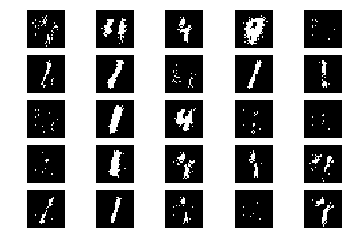

Epoch 60000
60000: [Discriminaotr loss: 0.032690, acc: 0.500000]  [GAN loss: 9.817235, acc: 0.000000]


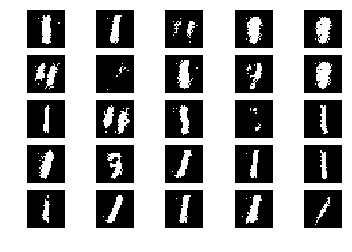

Epoch 70000
70000: [Discriminaotr loss: 0.034191, acc: 0.500000]  [GAN loss: 13.127508, acc: 0.000000]


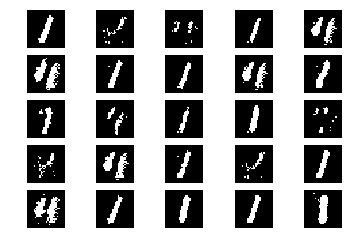

Epoch 80000
80000: [Discriminaotr loss: 0.039889, acc: 0.496094]  [GAN loss: 13.128239, acc: 0.000000]


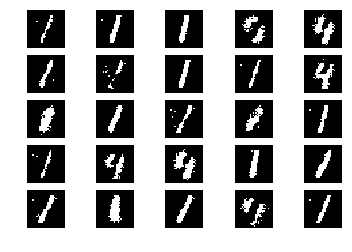

Epoch 90000
90000: [Discriminaotr loss: 0.034464, acc: 0.496094]  [GAN loss: 13.581603, acc: 0.000000]


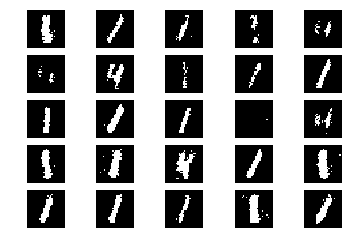

Epoch 100000
100000: [Discriminaotr loss: 0.031383, acc: 0.500000]  [GAN loss: 11.930386, acc: 0.000000]


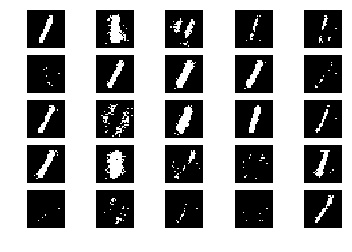

In [31]:
#Load MNIST data and normalize to [-1, 1]
# Fill this in
(data_train, _), (data_test, _) = mnist.load_data()
data_train = data_train/127.5 - 1
data_test = data_test/127.5 - 1
# The D-dimensional noise vector length
latent_dim = 100
data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return adam(lr=0.0002, beta_1=0.5, beta_2=0.999)

def gan_optimizer():
    return adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Genrerator model
def create_generator():
    generator=Sequential()
    generator.add(Dense(200, input_dim=latent_dim))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(500, input_dim=latent_dim))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(1000, input_dim=latent_dim))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(data_dim, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    return generator

# Discriminator model
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(1000, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(500, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(200, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dense(units=1,activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer= dis_optimizer(), metrics=['accuracy'])
    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim, ))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss = 'binary_crossentropy',
                optimizer=gan_optimizer(),
                metrics = ['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 128
sample_interval = 10000
noise_dim = batch_size*latent_dim

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(0, 0.3, (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake = generator.predict(noise)

    # Get a random set of real MNIST images
    random = np.random.randint(0, 60000, size=batch_size)
    reals = [data_train[i] for i in random]
    real = np.stack(reals).reshape(batch_size, data_dim)

    # Concatenate real and fake images into a single array (or batch)
    all = np.concatenate((fake, real),axis=0)

    # Assign training labels (assign high probability, but not 1, to real images)
    label_fake = np.repeat(0, batch_size)
    label_real = np.repeat(0.99, batch_size)
    label_discriminator = np.concatenate((label_fake, label_real), axis=0)

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(all, label_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise2 = np.random.normal(0, 0.3, (batch_size, latent_dim))
    label_generator = np.repeat(0.99, batch_size) # label of real data

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise2, label_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

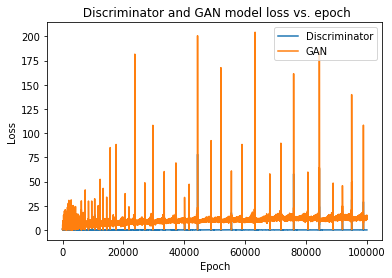

In [32]:
# Plot model loss vs epoch
plt.plot(training_meta_data[:,0])
plt.plot(training_meta_data[:,1])
plt.title(' Discriminator and GAN model loss vs. epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'GAN'], loc = 1)
plt.show()

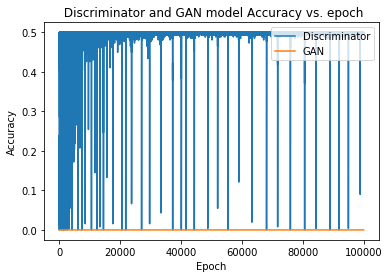

In [33]:
# Plot accuracy vs epoch
plt.plot(training_meta_data[:,2])
plt.plot(training_meta_data[:,3])
plt.title(' Discriminator and GAN model Accuracy vs. epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Discriminator', 'GAN'], loc = 1)
plt.show()

<br>

**4. Remove Dropout in discriminator and observe the difference.**

11501568/11490434 [==============================] - 5s 0us/step
Epoch 10000
10000: [Discriminaotr loss: 0.315325, acc: 0.492188]  [GAN loss: 1.873011, acc: 0.000000]


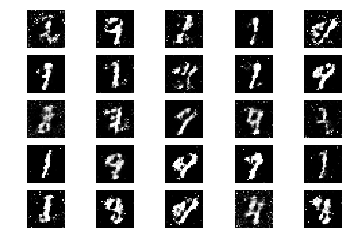

Epoch 20000
20000: [Discriminaotr loss: 0.354206, acc: 0.359375]  [GAN loss: 3.351251, acc: 0.000000]


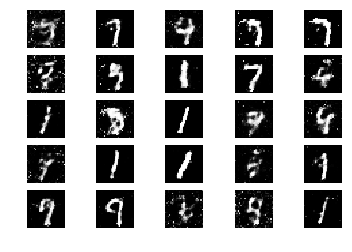

Epoch 30000
30000: [Discriminaotr loss: 0.377721, acc: 0.484375]  [GAN loss: 2.364040, acc: 0.000000]


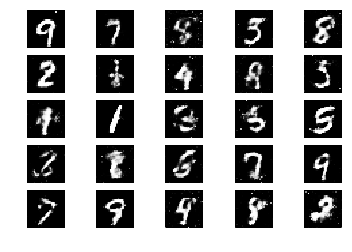

Epoch 40000
40000: [Discriminaotr loss: 0.434408, acc: 0.328125]  [GAN loss: 4.055158, acc: 0.000000]


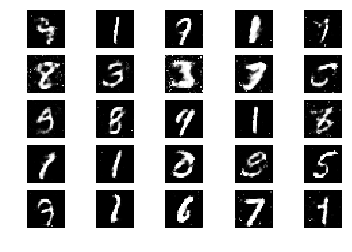

Epoch 50000
50000: [Discriminaotr loss: 0.292878, acc: 0.445312]  [GAN loss: 2.672796, acc: 0.000000]


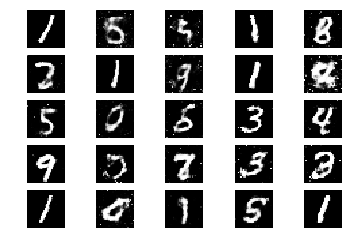

Epoch 60000
60000: [Discriminaotr loss: 0.279766, acc: 0.460938]  [GAN loss: 2.287472, acc: 0.000000]


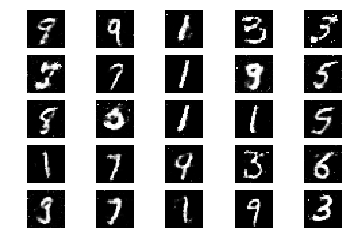

Epoch 70000
70000: [Discriminaotr loss: 0.279071, acc: 0.460938]  [GAN loss: 3.324697, acc: 0.000000]


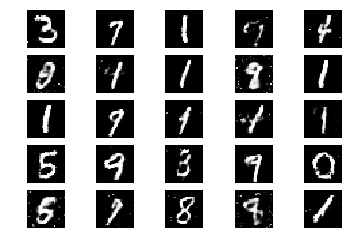

Epoch 80000
80000: [Discriminaotr loss: 0.287955, acc: 0.449219]  [GAN loss: 2.665831, acc: 0.000000]


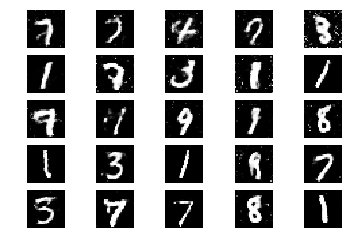

Epoch 90000
90000: [Discriminaotr loss: 0.309732, acc: 0.457031]  [GAN loss: 2.582267, acc: 0.000000]


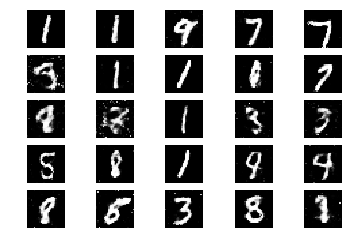

Epoch 100000
100000: [Discriminaotr loss: 0.258512, acc: 0.453125]  [GAN loss: 3.190614, acc: 0.000000]


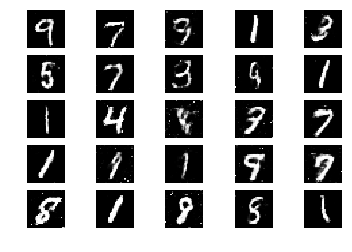

In [3]:
#Load MNIST data and normalize to [-1, 1]
# Fill this in
(data_train, _), (data_test, _) = mnist.load_data()
data_train = data_train/127.5 - 1
data_test = data_test/127.5 - 1
# The D-dimensional noise vector length
latent_dim = 100
data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return adam(lr=0.0002, beta_1=0.5, beta_2=0.999)

def gan_optimizer():
    return adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Genrerator model
def create_generator():
    generator=Sequential()
    generator.add(Dense(200, input_dim=latent_dim))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(500, input_dim=latent_dim))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(1000, input_dim=latent_dim))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(data_dim, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    return generator

# Discriminator model
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(1000, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dense(500, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dense(200, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dense(units=1,activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer= dis_optimizer(), metrics=['accuracy'])
    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim, ))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss = 'binary_crossentropy',
                optimizer=gan_optimizer(),
                metrics = ['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 128
sample_interval = 10000
noise_dim = batch_size*latent_dim

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(0, 0.3, (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake = generator.predict(noise)

    # Get a random set of real MNIST images
    random = np.random.randint(0, 60000, size=batch_size)
    reals = [data_train[i] for i in random]
    real = np.stack(reals).reshape(batch_size, data_dim)

    # Concatenate real and fake images into a single array (or batch)
    all = np.concatenate((fake, real),axis=0)

    # Assign training labels (assign high probability, but not 1, to real images)
    label_fake = np.repeat(0, batch_size)
    label_real = np.repeat(0.99, batch_size)
    label_discriminator = np.concatenate((label_fake, label_real), axis=0)

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(all, label_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise2 = np.random.normal(0, 0.3, (batch_size, latent_dim))
    label_generator = np.repeat(0.99, batch_size) # label of real data

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise2, label_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

<br>

**5a. Increase the dropout rate in each dropout layer by 0.1 and train the network.**

Epoch 10000
10000: [Discriminaotr loss: 0.029158, acc: 0.500000]  [GAN loss: 11.269241, acc: 0.000000]


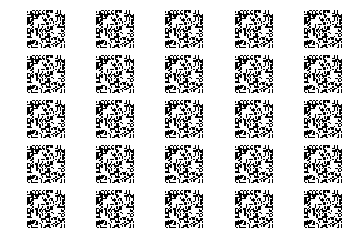

Epoch 20000
20000: [Discriminaotr loss: 0.028349, acc: 0.500000]  [GAN loss: 14.082501, acc: 0.000000]


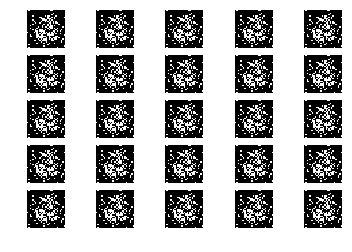

Epoch 30000
30000: [Discriminaotr loss: 0.028073, acc: 0.500000]  [GAN loss: 20.106295, acc: 0.000000]


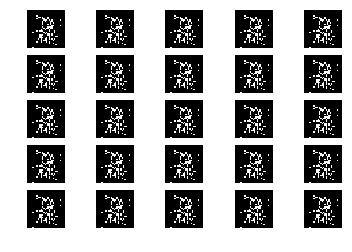

Epoch 40000
40000: [Discriminaotr loss: 0.028030, acc: 0.500000]  [GAN loss: 20.808174, acc: 0.000000]


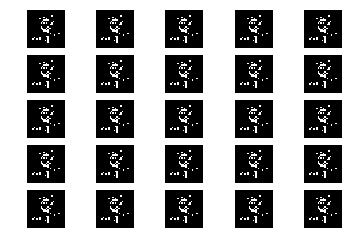

Epoch 50000
50000: [Discriminaotr loss: 0.028054, acc: 0.500000]  [GAN loss: 18.239328, acc: 0.000000]


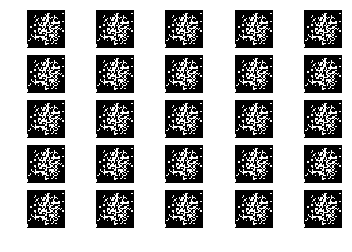

Epoch 60000
60000: [Discriminaotr loss: 0.028027, acc: 0.500000]  [GAN loss: 19.390530, acc: 0.000000]


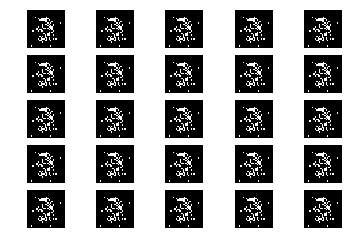

Epoch 70000
70000: [Discriminaotr loss: 0.028177, acc: 0.500000]  [GAN loss: 14.719905, acc: 0.000000]


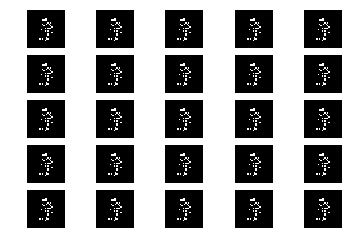

Epoch 80000
80000: [Discriminaotr loss: 0.028002, acc: 0.500000]  [GAN loss: 19.587566, acc: 0.000000]


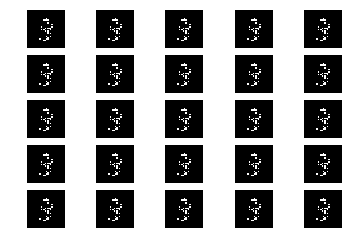

Epoch 90000
90000: [Discriminaotr loss: 0.028016, acc: 0.500000]  [GAN loss: 17.959503, acc: 0.000000]


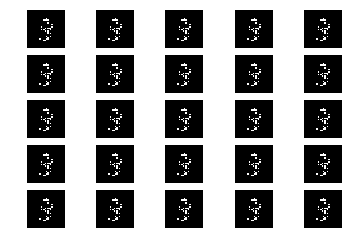

Epoch 100000
100000: [Discriminaotr loss: 0.028587, acc: 0.500000]  [GAN loss: 10.231426, acc: 0.000000]


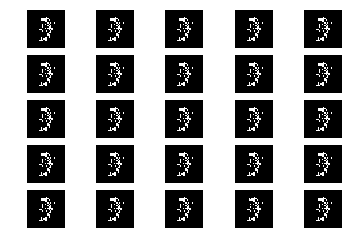

In [4]:
#Load MNIST data and normalize to [-1, 1]
# Fill this in
(data_train, _), (data_test, _) = mnist.load_data()
data_train = data_train/127.5 - 1
data_test = data_test/127.5 - 1
# The D-dimensional noise vector length
latent_dim = 100
data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return adam(lr=0.0002, beta_1=0.5, beta_2=0.999)

def gan_optimizer():
    return adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Genrerator model
def create_generator():
    generator=Sequential()
    generator.add(Dense(200, input_dim=latent_dim))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(500, input_dim=latent_dim))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(1000, input_dim=latent_dim))
    generator.add(LeakyReLU(0.5))
    generator.add(Dense(data_dim, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
    return generator

# Discriminator model
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(1000, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
    discriminator.add(Dense(500, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dropout(0.5))
    discriminator.add(Dense(200, input_dim=data_dim))
    discriminator.add(LeakyReLU(0.5))
    discriminator.add(Dense(units=1,activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer= dis_optimizer(), metrics=['accuracy'])
    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim, ))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss = 'binary_crossentropy',
                optimizer=gan_optimizer(),
                metrics = ['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 128
sample_interval = 10000
noise_dim = batch_size*latent_dim

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(0, 0.3, (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake = generator.predict(noise)

    # Get a random set of real MNIST images
    random = np.random.randint(0, 60000, size=batch_size)
    reals = [data_train[i] for i in random]
    real = np.stack(reals).reshape(batch_size, data_dim)

    # Concatenate real and fake images into a single array (or batch)
    all = np.concatenate((fake, real),axis=0)

    # Assign training labels (assign high probability, but not 1, to real images)
    label_fake = np.repeat(0, batch_size)
    label_real = np.repeat(0.99, batch_size)
    label_discriminator = np.concatenate((label_fake, label_real), axis=0)

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(all, label_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise2 = np.random.normal(0, 0.3, (batch_size, latent_dim))
    label_generator = np.repeat(0.99, batch_size) # label of real data

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise2, label_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

[4]. Compare and comment on the results of GAN with dropout and without dropout.<br>
**Answer**: The accuracy of generator with dropout is greater than generator without dropout layers. The GAN loss of generator with dropout is less than generator without dropout. We know that dropout layers efficiently prevent overfitting. On the other hand, from the images we could see that the digits without dropout layers are clear than the other one, which could be a sign of overfitting and GAN loss. 
<br>


[5][a]. Comment on importance of hyper-parameter tuning <br>
**Answer**: Increasing the dropout rate by 0.1 decreases the quality of generated images. Since the parameters are sensitive we could conclude that changing the dropout rate will probably get incorrect results and affect our judgement of the generator. 

**Bonus [5][b] Answer**:
Modify the noise rate from <br>
noise = np.random.normal(0, 0.3, (batch_size, latent_dim)) to<br>
noise = np.random.normal(0, 1, (batch_size, latent_dim)) will definitely improve the performance of the image quality. Since the range of noise is enlarged, the ability of generator will be improved, which helps are better assess the images of the trained generator.<br>


[6]. Answer the following questions:<br> 

1.   Why does the accuracy of the discriminator remain around 50%? Is this a good trait of the GAN? 

  **ANS**: When the generator improves with the training process, the performance of discriminator gets worse since it is hard to it to distinguish real and fake images. When the accuracy of discriminator is fixed at 50% or nearly 50%, we know that the generator works well. 


2.   How could this model be modified to produce cleaner (less noisy) images? 

  **ANS**: We know that the hyperparameters are extremely and will change the quality of the images easily. To denoise the image, we could modify <br>
  1. The default value of beta in the optimizer.<br>
  2. The dropout rate and the noise distribution. Appropriate value for dropout is essential since both 0.5 and 0.3 don't perform well on my generated images.<br>
  3. Reduce leaky RELU value.<br>

#Part 2: Generating samples using trained generator

In [ ]:
# Generate ten images from Gaussian noise using the trained generator from Part 1
#noise = np.random.normal(0, 1, (batch_size, latent_dim))
input_noise = generator.predict(noise)
# Re-scale generated images to lie in [0, 1]
generated_images = 0.5 * input_noise + 0.5

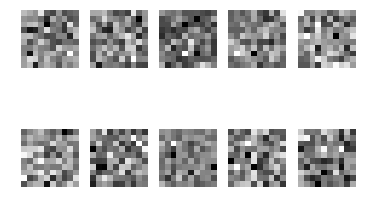

In [ ]:
# Visualize generated noise
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((noise[cnt].reshape(10, 10)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

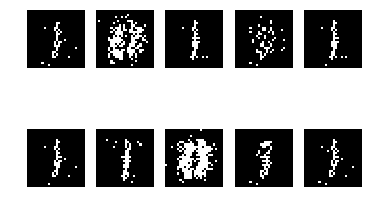

In [ ]:
# Visualize generated samples
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((generated_images[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

#Part 3: Testing accuracy of generated images on ten samples

In [13]:
# Load mnist classifier and generated images
mnist_classifier = load_model('mnist_classifier.h5')

In [ ]:
# ASSIGN CLASSES
labels = [1, 0, 1, 8, 1, 1, 1, 0, 7, 1]
labels_value1 = []
labels_value1 = np.copy(labels)
labels_value1 = np.array(labels_value1)

# Convert integer labels to one-hot labels 
labels = keras.utils.np_utils.to_categorical(labels, num_classes=10)

# Show classifications
prediction = mnist_classifier.predict(generated_images[0:10])
labels_true_classifier = np.argmax(prediction, axis = 1) # print the classifier index to compare with the pre-trained labels
accuracy = accuracy_score(labels_value1, labels_true_classifier)
print('The classification is ', labels_true_classifier)
# Evaluate accuracy
print('The accuracy of the classifier is ', accuracy)

The classification is  [1 0 1 8 1 1 1 0 7 1]
The accuracy of the classifier is  1.0


Question 3a:<br>
From the accuracy we could see that the generator does well on the classification. However, some digits are ambiguous on the generated images, which needs to be improved. The problem that causes the confusion could be the hyperparameters or dropout layers. The generator could succefully print similar images but not precise. 
<br>
<br>
Question 3b:<br>
To better evaluate the quality of the images, we could augment the samples of generated images or increase the epoches to improve the image quality. From the generating process we could see that the more step we take, the more accurate the images are.